In [1]:
from functions import *

# Figure 9

/var/folders/dv/4xxtrbpd4ql97bd1_v6ctglh0000gn/T/ipykernel_30046/142652200.py:79: RuntimeWarning: All-NaN slice encountered
  w = abs(np.nanmin(cleanVi[indexMinimum:,:])) # horizontal nanmin of vertical velocities IT ALSO WORKS WITH nanmean
/Users/edoardo/opt/anaconda3/envs/meltingAnaconda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


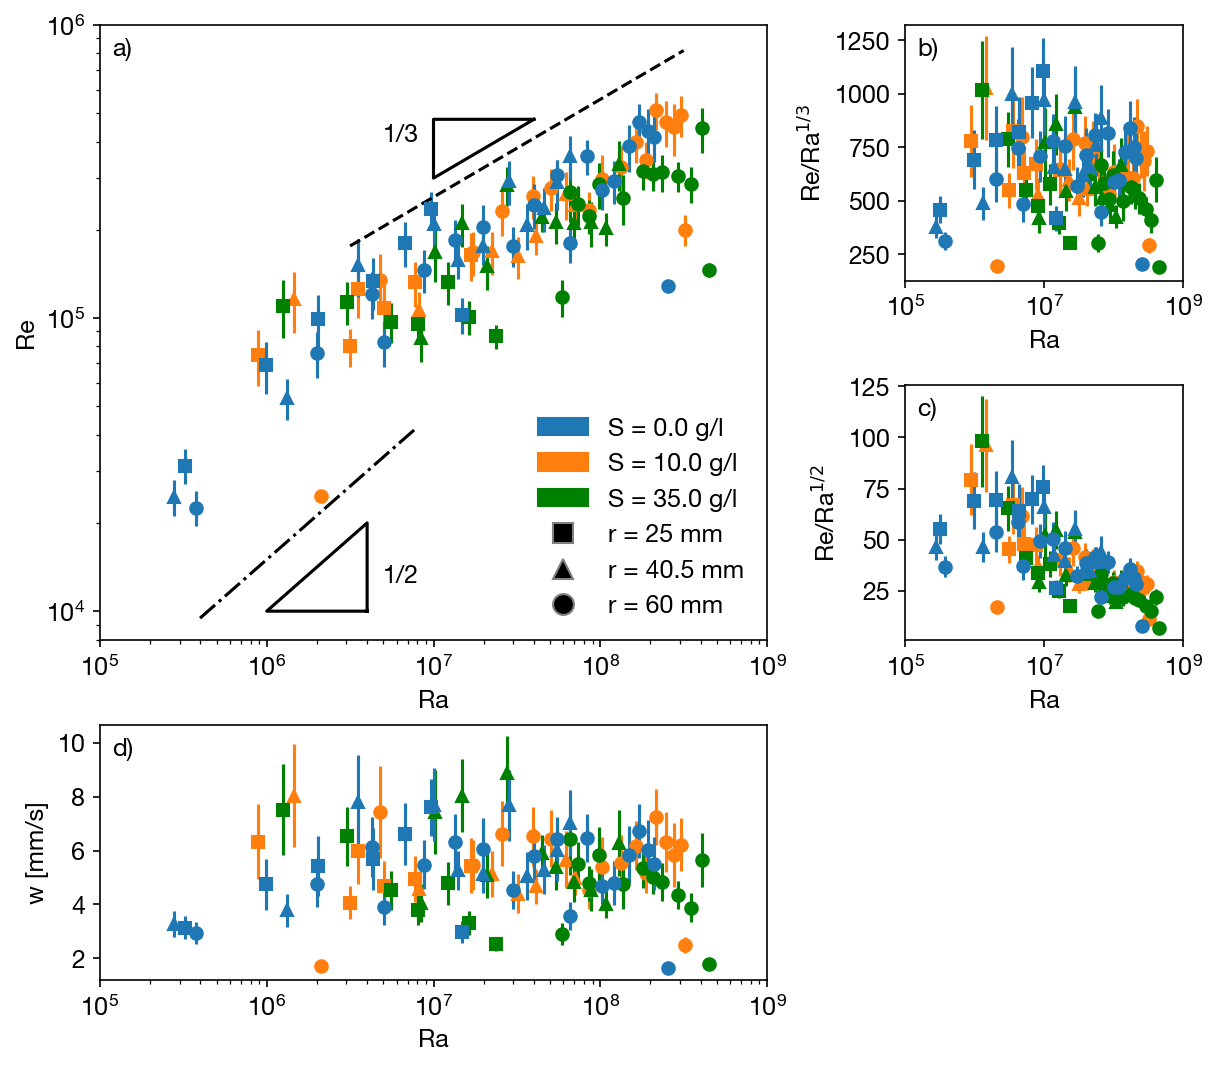

In [5]:
def Ra_salinity(r,T1,T2,S=0):
    """Calculates Rayleigh number for a cylinder in (possibly salty) water, given radius,salinity, and two temperatures. 
    The density is calculated according to Millero and Huang, 2009.

    Args:
        r (float): cylinder's radius [m]
        S (float,optional): water salinity [g/l], Defaults to 0 g/l.
        T1 (float): temperature 1 [degC]
        T2 (float): temperature 2 [degC]

    Returns:
        float: Rayleigh number
    """    
    T_min = min(T1,T2)
    T_max = max(T1,T2)
    rho1 = MH_rho(T_min,S=S) # fresh, cold water
    rho2 = MH_rho(T_max,S=S)
    rho_avg = np.mean((rho1,rho2))

    deltaRho = abs(rho1-rho2)
    return g*deltaRho*(2*r)**3/(alpha*nu*rho_avg)


myColours = np.repeat(['tab:blue','tab:orange','green','purple','red','cyan','brown','pink','grey','olive',
                       'black','lime'],1)
myMarkers = ['s','^','o']

pivDirectory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-06/'
chosen_salts,chosen_radii = [0.,10.,35.],[0.025,0.0405,0.06]

fig, axs = plt.subplot_mosaic([['a)', 'a)','b)'], ['a)','a)', 'c)'],['d)','d)','.']],
                              layout='constrained',dpi=150,width_ratios=[1.2, 1.2, 1],
                              figsize=(8,7))

it=-1
folders = []
abscissa = []
ordinate = []
error = []

for folder in glob.glob(pivDirectory+'*'):
    folders.append(folder)
folders = np.sort(folders)

for _,folder in enumerate(folders):
    if 'NR' in folder or 'analysis' in folder: continue # there are folders with no good data in them
    date = folder[93:99]
    timestring = folder[105:111]
    exp_sal = float(folder[113:115])
    exp_radius = int(folder[116:118])/2000
    if exp_radius == 0.006: exp_radius=0.06
    
    if exp_radius not in chosen_radii or exp_sal not in chosen_salts:
        continue
    else:
        it +=1

    if timestring == '120643': 
        it -= 1
        continue # THIS SKIPS A BAD IMAGE ON THE .0405 S00 DATA

    timeOfExp = np.datetime64(f'20{date[:2]}-{date[2:4]}-{date[-2:]}T{timestring[:2]}:{timestring[2:4]}:{timestring[-2:]}')

    # read PIV data
    pivData = np.genfromtxt(glob.glob(folder+'/*.txt')[0]).T
    x,y,u,v = pivData
    side = np.sqrt(x.shape[0]).astype(int)

    # regularly spaced grid spanning the domain of x and y 
    xi = np.linspace(x.min(), x.max(), side)
    yi = np.linspace(y.min(), y.max(), side)
    X,Y = np.meshgrid(xi,yi)

    ui = np.reshape(u,(side,side))[::-1,:]
    vi = np.reshape(v,(side,side))[::-1,:]

    cleanVi = np.where(vi>-0.0015,np.nan,vi) # simple thresholding of vertical velocities. 
    indexMinimum = np.min(-(contour/1024*128)[:,1].astype(int))-2 # location of bottom of ice
    w = abs(np.nanmin(cleanVi[indexMinimum:,:])) # horizontal nanmin of vertical velocities IT ALSO WORKS WITH nanmean
    wstd = abs(np.nanstd(cleanVi[indexMinimum:,:]))

    # read contorus data and make average Ra (over 2 shots...)
    Rayleigh_numbers = 0
    for ic,contourPATH in enumerate(glob.glob(folder+'/*.csv')):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])*.917/np.pi) # CORRECTION TO CONSIDER ONLY IMMERSED PART.
        conversion = 1024*1000/abs(yi[-1]-yi[0]) # px/m
        radius /= conversion
        Rayleigh_numbers += Ra_salinity(radius,4,20.,S=exp_sal)
    Rayleigh_numbers /= ic

    axs['a)'].errorbar(x=Rayleigh_numbers,
                 y=w*1000*2*radius/nu,
                 yerr=wstd*1000*2*radius/nu,
                 marker=myMarkers[np.where(chosen_radii==find_nearest(chosen_radii,exp_radius))[0][0]],
                 c=myColours[np.where(chosen_salts==find_nearest(chosen_salts,exp_sal))[0][0]])
    if not np.isnan(w):
        abscissa.append(Rayleigh_numbers)
        ordinate.append(w*1000*2*radius/nu)
        error.append(wstd*1000*2*radius/nu)
    axs['b)'].errorbar(x=Rayleigh_numbers,
                 y=w*1000*2*radius/nu/ Rayleigh_numbers**(1/3),
                 yerr=wstd*1000*2*radius/nu / Rayleigh_numbers**(1/3),
                 marker=myMarkers[np.where(chosen_radii==find_nearest(chosen_radii,exp_radius))[0][0]],
                 c=myColours[np.where(chosen_salts==find_nearest(chosen_salts,exp_sal))[0][0]])
    axs['c)'].errorbar(x=Rayleigh_numbers,
                 y=w*1000*2*radius/nu/ Rayleigh_numbers**(1/2),
                 yerr=wstd*1000*2*radius/nu / Rayleigh_numbers**(1/2),
                 marker=myMarkers[np.where(chosen_radii==find_nearest(chosen_radii,exp_radius))[0][0]],
                 c=myColours[np.where(chosen_salts==find_nearest(chosen_salts,exp_sal))[0][0]])
    axs['d)'].errorbar(x=Rayleigh_numbers,
                 y=w*1000,
                 yerr=wstd*1000,
                 marker=myMarkers[np.where(chosen_radii==find_nearest(chosen_radii,exp_radius))[0][0]],
                 c=myColours[np.where(chosen_salts==find_nearest(chosen_salts,exp_sal))[0][0]])
    

axs['a)'].plot(np.logspace(6.5,8.5,50),1200*np.logspace(6.5,8.5,50)**(1/3),linestyle='--',c='k')
axs['a)'].annotate('1/2', xy=(5e6,1.25e4))
axs['a)'].plot([4e6,4e6,1e6,4e6],[1e4,4**(1/2)*1e4,1e4,1e4],c='k')
axs['a)'].plot(np.logspace(5.6,6.9,50),15*np.logspace(5.6,6.9,50)**(1/2),linestyle='-.',c='k')
axs['a)'].annotate('1/3', xy=(5e6,4e5))
axs['a)'].plot([4e7,1e7,1e7,4e7],[4**(1/3)*3e5,4**(1/3)*3e5,3e5,4**(1/3)*3e5],c='k')
for label,axi in axs.items():
    axi.set(xlabel='Ra',xscale='log',
            xlim=(1e5,1e9))
    axi.annotate(
        label,
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        verticalalignment='top',
        bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
axs['a)'].set(ylabel='Re',ylim=(10**3.9,10**6.0),yscale='log')
axs['b)'].set(ylabel=r'Re/Ra$^{1/3}$')
axs['c)'].set(ylabel=r'Re/Ra$^{1/2}$')
axs['d)'].set(ylabel='w [mm/s]')

# access legend objects automatically created from data
handles, labels = axs['a)'].get_legend_handles_labels()

# create manual symbols for legend
patch0 = mpatches.Patch(color=myColours[0], label='S = 0.0 g/l')   
patch1 = mpatches.Patch(color=myColours[1], label='S = 10.0 g/l')   
patch2 = mpatches.Patch(color=myColours[2], label='S = 35.0 g/l')   
point0 = Line2D([0], [0], label='r = 25 mm', marker=myMarkers[0], markersize=10, 
         markeredgecolor='grey', markerfacecolor='k', linestyle='')
point1 = Line2D([0], [0], label='r = 40.5 mm', marker=myMarkers[1], markersize=10, 
         markeredgecolor='grey', markerfacecolor='k', linestyle='')
point2 = Line2D([0], [0], label='r = 60 mm', marker=myMarkers[2], markersize=10, 
         markeredgecolor='grey', markerfacecolor='k', linestyle='')

# add manual symbols to auto legend
handles.extend([patch0, patch1, patch2, point0,point1,point2])
axs['a)'].legend(handles=handles,loc='lower right',frameon=False)

# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/ReRa.pdf',format='pdf',bbox_inches='tight')
plt.show()